In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

dist_pickle = pickle.load( open("data_slow.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

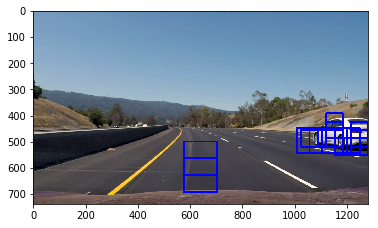

In [2]:
color_space = 'YCrCb'
hog_channel = 'ALL'

from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True: # then no ALL channel available 
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features, hog_image = hog(gray, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        if hog_channel == 'ALL':
            hog_features = []
            
            for channel in range(img.shape[2]):
                hog_features.extend(hog(img[:,:,channel], orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec))      
        else:
            hog_features = hog(img[:,:,hog_channel], orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        
        #features = hog(img, orientations=orient, 
        #               pixels_per_cell=(pix_per_cell, pix_per_cell),
        #               cells_per_block=(cell_per_block, cell_per_block), 
        #               transform_sqrt=False, 
        #               visualise=vis, feature_vector=feature_vec)
        return hog_features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)     
    # Use cv2.resize().ravel() to create the feature vector
    small_img = cv2.resize(feature_image, size)
    features = small_img.ravel() 
    # Return the feature vector
    return features
    
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features    
    


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    #print("shape of img:",img.shape)
    #print("x start stop:",x_start_stop)
    if(x_start_stop==[None,None]):
        x_start_stop = [0,img.shape[1]]
        #print("yeah")
        
    if(y_start_stop==[None,None]):
        y_start_stop = [0,img.shape[0]]
        #print("here")
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    x_step = float(xy_window[0])*float(xy_overlap[0])
    y_step = xy_window[1]*xy_overlap[1]
    #print("x_step:",x_step)
    #print("y_step:",y_step)
    # Compute the number of windows in x/y
    x_num_win = ((x_start_stop[1]-x_start_stop[0]-xy_window[0])/x_step)+1
    y_num_win = ((y_start_stop[1]-y_start_stop[0]-xy_window[1])/y_step)+1
    #print("x num win:",x_num_win)
    #print("y num win:",y_num_win) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for y in range(0,int(y_num_win)):
        #print("y:",y)
        y_start = int(y_start_stop[0]+y_step*y)
        y_stop = int(y_start_stop[0]+xy_window[1]+ y_step*y)
        for x in range(0,int(x_num_win)):
            #print("x:",x)
            x_start = int(x_start_stop[0]+x_step*x)
            x_stop = int(xy_window[0]+x_step*x)
            window_list.append(((x_start,y_start),(x_stop,y_stop)))
        
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list

"""
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()
"""

def single_img_features(img, cspace='RGB', spatial_size=(32, 32)):
    #image = mpimg.imread(img)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            bin_feature = bin_spatial(img, color_space='HSV', size=spatial_size)
        elif cspace == 'LUV':
            bin_feature = bin_spatial(img, color_space='LUV', size=spatial_size)
        elif cspace == 'HLS':
            bin_feature = bin_spatial(img, color_space='HLS', size=spatial_size)
        elif cspace == 'YUV':
            bin_feature = bin_spatial(img, color_space='YUV', size=spatial_size)
        elif cspace == 'YCrCb':
            bin_feature = bin_spatial(img, color_space='YCrCb', size=spatial_size)
    else:
        bin_feature = bin_spatial(img, color_space='RGB', size=spatial_size)  

    # Apply color_hist() to get color histogram features
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_feature = get_hog_features(img, orient, 
                    pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True)
    color_hist_feature = color_hist(img,nbins=hist_bins, bins_range=(0, 1))
    # Append the new feature vector to the features list
    combined_features = np.concatenate((bin_feature,hog_feature,color_hist_feature))
        
    # Return list of feature vectors
    return combined_features



# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32)):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #print("all four num:",window[0][1])
        #print("all four num:",window[1][1])
        #print("all four num:",window[0][0])
        #print("all four num:",window[1][0])
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
        #4) Extract features for that window using single_img_features()
        
        features = single_img_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Create an array stack of feature vectors
        #X = np.vstack((features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        #X_scaler = StandardScaler().fit(test_features)
        # Apply the scaler to X
        #scaled_X = X_scaler.transform(test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = mpimg.imread('test_images/snapshot02.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255


#windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))



windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360,600], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,600], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[500,720], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

windows = []

windows.extend(windows1)
windows.extend(windows2)
windows.extend(windows3)

#print("windows shape:",len(windows),"windows1",len(windows1),"window2",len(windows2),"windows3",len(windows3))

hot_windows = search_windows(image, windows, svc, X_scaler, cspace=color_space, 
                        spatial_size=spatial_size)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()



(738, 1280)
(738, 1280)


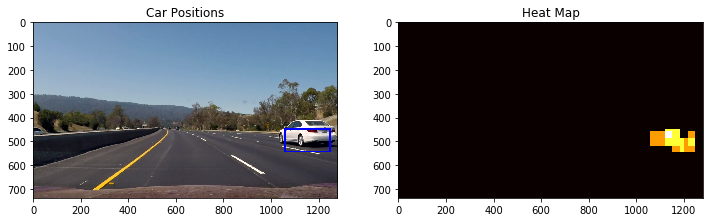

In [3]:
# Adding heat box
from scipy.ndimage.measurements import label
# Read in image similar to one shown above 
image = mpimg.imread('test_images/snapshot06.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
print(heat.shape)  
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)
print(heat.shape)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.show()

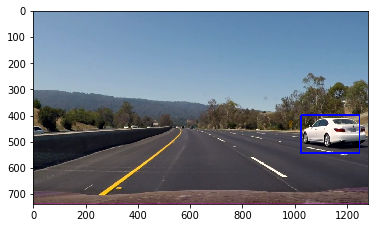

In [4]:
#start to process video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections

# fail on lesson 35 try lesson 34 
spatial_size=(32, 32)

global heatmaps
heatmaps = collections.deque(maxlen=10) 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap_sum = np.zeros_like(image[:,:,0]).astype(np.float)
global counter 
counter = 0

def process_image(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    #current_heatmaps = np.zeros_like(image[:,:,0]).astype(np.float)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    hot_windows = []
    global counter
    global heatmaps
    
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360,600], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[500,720], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows = []
    windows.extend(windows1)
    windows.extend(windows2)
    windows.extend(windows3)
    
    hot_windows = search_windows(image, windows, svc, X_scaler, cspace=color_space, 
                        spatial_size=spatial_size)
    
    current_heatmaps = add_heat(heat,hot_windows)
    #print(heat.shape)
    current_heatmaps= apply_threshold(current_heatmaps,2)
    #print(heat.shape)
    # Visualize the heatmap when displaying    
    current_heatmaps = np.clip(current_heatmaps, 0, 255)
    heatmaps.append(current_heatmaps)
    heatmap_sum = sum(heatmaps)
    if(counter % 10 ==9):
        print("e")
        heatmap_sum = apply_threshold(heatmap_sum,20)
        
    labels = label(heatmap_sum)
    #labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    #draw_img = draw_boxes(image,hot_windows,color=(0, 0, 255), thick=6)
    if(counter % 10 ==9):
        print("f")
        #heatmap_sum = apply_threshold(heatmap_sum,20)
        heatmap_sum = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        current_heatmaps = np.zeros_like(image[:,:,0]).astype(np.float)
    counter += 1
    return draw_img

img = mpimg.imread('test_images/snapshot06.jpg')

pro_img = process_image(img)
plt.imshow(pro_img)
plt.show()

In [5]:
white_output = 'project_video_cut04_output_slow_resetatBegin.mp4'
clip1 = VideoFileClip("project_video_cut04.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

ValueError: operands could not be broadcast together with shapes (738,1280) (720,1280) 